In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import pickle

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
data = pd.read_csv("data_titanic_proyecto.csv")

## Analisis de variables

In [3]:
data.head(5)

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


Se busca eliminar las variables especificas y dejar unicamente las generales

In [4]:
columns_to_delete = ['PassengerId', 'Name', 'Ticket']
label_column = ['passenger_survived']

data = data.drop(columns=columns_to_delete)

In [5]:
data.head(5)

,Age,SibSp,Parch,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,7.2500,NaN,S,Lower,M,N
1,38.0,1,0,71.2833,C85,C,Upper,F,Y
2,26.0,0,0,7.9250,NaN,S,Lower,F,Y
3,35.0,1,0,53.1000,C123,S,Upper,F,Y
4,35.0,0,0,8.0500,NaN,S,Lower,M,N


In [6]:
data.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


Revision de nulos para posibles imputaciones

In [7]:
for col in data.columns:
    cant_nulls = data[col].isna().sum()
    cant_regs = len(data[col])
    print(col)
    print(f'Cantidad de nulos: {cant_nulls}')
    print(f'Porcentage de nulos: {round(cant_nulls/cant_regs*100, 2)}% \n')

Age
Cantidad de nulos: 177
Porcentage de nulos: 19.87% 

SibSp
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Parch
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Fare
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Cabin
Cantidad de nulos: 687
Porcentage de nulos: 77.1% 

Embarked
Cantidad de nulos: 2
Porcentage de nulos: 0.22% 

passenger_class
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

passenger_sex
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

passenger_survived
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 



Para concluir que variables son utiles usare un umbral donde si tiene mas del 10% de nulos, la variable sera sacada del dataset de entrenamietno debido a que hacer una imputacion sobre mas del 20% de la data puede llegar a modificar mucho la distribucion de esta. Bajo este criterio las variables Cabin queda fuera del dataset.

In [8]:
data = data.drop(columns=['Cabin'])

Imputacion de valores para variable Age y Embarked

In [9]:
data['Age'].fillna(int(data['Age'].mean()), inplace = True)
data['Embarked'].fillna(data['Embarked'].value_counts().index[0], inplace = True)

In [10]:
for col in data.columns:
    cant_nulls = data[col].isna().sum()
    cant_regs = len(data[col])
    print(col)
    print(f'Cantidad de nulos: {cant_nulls}')
    print(f'Porcentage de nulos: {round(cant_nulls/cant_regs*100, 2)}% \n')

Age
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

SibSp
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Parch
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Fare
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Embarked
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

passenger_class
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

passenger_sex
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

passenger_survived
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 



Traduccion de variables categoricas a numericas, esto porque no todos los algoritmos que utilizaremos son capaces de recibir como entrada las categorias directamente como es el caso de los arboles de desion.

In [11]:
categorical_variables = ['Embarked', 'passenger_class', 'passenger_sex', 'passenger_survived']
dictionaries = {}

for col in categorical_variables:
    values = data[col].unique()
    dictionaries[col] = {'word_to_number': {values[number]: number for number in range(len(values))}}
    data[col] = data[col].apply(lambda x: dictionaries[col]['word_to_number'][x])
dictionaries

{'Embarked': {'word_to_number': {'S': 0, 'C': 1, 'Q': 2}},
 'passenger_class': {'word_to_number': {'Lower': 0, 'Upper': 1, 'Middle': 2}},
 'passenger_sex': {'word_to_number': {'M': 0, 'F': 1}},
 'passenger_survived': {'word_to_number': {'N': 0, 'Y': 1}}}

In [12]:
data.head(5)

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,7.2500,0,0,0,0
1,38.0,1,0,71.2833,1,1,1,1
2,26.0,0,0,7.9250,0,0,1,1
3,35.0,1,0,53.1000,0,1,1,1
4,35.0,0,0,8.0500,0,0,0,0


Revision de distribucion de variables numericas

AGE


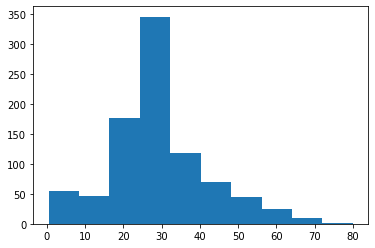

SIBSP


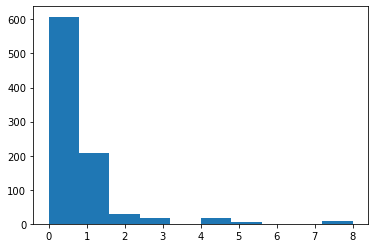

PARCH


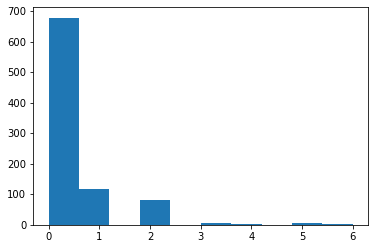

FARE


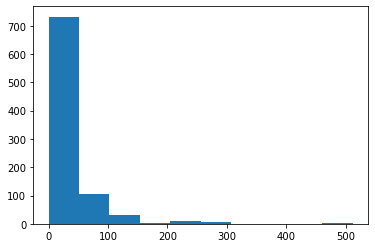

In [13]:
for col in data.columns[0:4]:
    print(col.upper())
    plt.hist(data[col])
    plt.show()

Particion de los datasets

In [14]:
X_train, X_later, y_train, y_later = train_test_split(data.iloc[:, 1:-1], data.iloc[:, -1], test_size=0.4, random_state=42)

In [15]:
X_test, X_validation, y_test, y_validation = train_test_split(X_later, y_later, test_size=0.5, random_state=42)

In [16]:
X_train.shape, X_test.shape, X_validation.shape, y_train.shape, y_test.shape, y_validation.shape

((534, 6), (178, 6), (179, 6), (534,), (178,), (179,))

In [17]:
X_train

,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex
570,0,0,10.5000,0,2,0
787,4,1,29.1250,2,0,0
74,0,0,56.4958,0,0,0
113,1,0,9.8250,0,0,1
635,0,0,13.0000,0,2,1
...,...,...,...,...,...,...
106,0,0,7.6500,0,0,1
270,0,0,31.0000,0,1,0
860,2,0,14.1083,0,0,0
435,1,2,120.0000,0,1,1


In [18]:
y_train

570    1
787    0
74     1
113    0
635    1
      ..
106    1
270    0
860    0
435    1
102    0
Name: passenger_survived, Length: 534, dtype: int64

In [19]:
np.array(X_train)

array([[  0.    ,   0.    ,  10.5   ,   0.    ,   2.    ,   0.    ],
       [  4.    ,   1.    ,  29.125 ,   2.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,  56.4958,   0.    ,   0.    ,   0.    ],
       ...,
       [  2.    ,   0.    ,  14.1083,   0.    ,   0.    ,   0.    ],
       [  1.    ,   2.    , 120.    ,   0.    ,   1.    ,   1.    ],
       [  0.    ,   1.    ,  77.2875,   0.    ,   1.    ,   0.    ]])

In [20]:
X_train

,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex
570,0,0,10.5000,0,2,0
787,4,1,29.1250,2,0,0
74,0,0,56.4958,0,0,0
113,1,0,9.8250,0,0,1
635,0,0,13.0000,0,2,1
...,...,...,...,...,...,...
106,0,0,7.6500,0,0,1
270,0,0,31.0000,0,1,0
860,2,0,14.1083,0,0,0
435,1,2,120.0000,0,1,1


Entrenamiento

In [45]:
class NaiveModel():
    def __init__(self):
        self.true_frequencies = {}
        self.false_frequencies = {}

    def fit(self, x_train, y_train):
        true_registers = x_train[y_train==1]
        false_registers = x_train[y_train==0]

        true_prior = len(true_registers)/len(x_train)
        false_prior = len(false_registers)/len(x_train)

        self.true_frequencies = {col:{index: row[0]/len(true_registers) for index, row in  pd.DataFrame(true_registers[col].value_counts()).iterrows()} for col in true_registers.columns}
        self.false_frequencies = {col:{index: row[0]/len(false_registers) for index, row in  pd.DataFrame(false_registers[col].value_counts()).iterrows()} for col in false_registers.columns}

    def predict(self, x):

        positive_predictions = x.apply(lambda row: np.prod([self.true_frequencies[col].get(row[col], 0.001) for col in x.columns]), axis=1)
        negative_predictions = x.apply(lambda row: np.prod([self.false_frequencies[col].get(row[col], 0.001) for col in x.columns]), axis=1)

        return (positive_predictions > negative_predictions) * 1
        
def params_parser(conf_string: str):
    params = conf_string.split('_')
    return {**{'model': params[0], 'plain_conf': conf_string}, **{param.split('=')[0]: param.split('=')[1] for param in params[1:]}}

def save_metrics(csv_name='bitacora.csv', **kwargs):
    df = pd.DataFrame({'plain_conf': [kwargs.get('plain_conf')], 
                       'accuracy': [kwargs.get('accuracy')], 
                       'error': [kwargs.get('error')], 
                       'precision': [kwargs.get('precision')], 
                       'recall': [kwargs.get('recall')], 
                       'f1': [kwargs.get('f1')]})
    temp_read = pd.read_csv(csv_name)
    new_df = pd.concat([temp_read, df])
    new_df.to_csv(csv_name, index=0)

def decisiontree(x, y, x_validation, y_validation, params):
    dc = DecisionTreeClassifier(random_state=42, 
                                criterion=params.get('criterion', 'gini'),
                                splitter=params.get('splitter', 'best'),
                                max_depth=int(params.get('maxdepth', None)),
                                min_samples_split=int(params.get('minsamplessplit', 2)))
    dc.fit(np.array(x), np.array(y))
    predictions = dc.predict(np.array(x_validation))
    save_metrics(plain_conf=params['plain_conf'], 
                 accuracy=accuracy_score(np.array(y_validation), predictions), 
                 precision=precision_score(y_validation, predictions), 
                 recall=recall_score(y_validation, predictions), 
                 f1=f1_score(y_validation, predictions))
    save_model(dc, params['plain_conf'])
    print("Finished")
    
def svm(x, y, x_validation, y_validation, params):
    sv = SVC(kernel=params.get('kernel', 'rbf'),
             degree=int(params.get('degree', 3)),
             gamma=params.get('gamma', 'scale'))
    sv.fit(x, y)
    predictions = sv.predict(np.array(x_validation))
    save_metrics(plain_conf=params['plain_conf'], 
                 accuracy=accuracy_score(np.array(y_validation), predictions), 
                 precision=precision_score(y_validation, predictions), 
                 recall=recall_score(y_validation, predictions), 
                 f1=f1_score(y_validation, predictions))
    save_model(sv, params['plain_conf'])
    print("Finished")

def naivebayes(x, y, x_validation, y_validation, params):
    params['features'] = [x.columns[int(col_index)] for col_index in params['features'].split(',')]
    print(params['features'])
    x_train = x[params['features']]
    x_validation = x_validation[params['features']]
    
    nv = NaiveModel()
    nv.fit(x_train, y)
    predictions = nv.predict(x_validation)
    save_metrics(plain_conf=params['plain_conf'], 
                 accuracy=accuracy_score(np.array(y_validation), predictions), 
                 precision=precision_score(y_validation, predictions), 
                 recall=recall_score(y_validation, predictions), 
                 f1=f1_score(y_validation, predictions))
    save_model(nv, params['plain_conf'])
    print('Finished')

def lg(x, y, x_validation, y_validation, params):
    pass

def train(conf_string: str, x_train, y_train, x_validation, y_validation):
    params = params_parser(conf_string)
    return eval(params['model'])(x_train, y_train, x_validation, y_validation, params)

def save_model(model_obj, name: str):
    joblib.dump(model_obj, f'{name}.pkl')
    
def load_model(name: str):
    return joblib.load(name)

In [46]:
test_dt_conf = "naivebayes_features=0,1,3,4,5"
train(test_dt_conf, X_train, y_train, X_validation, y_validation)

['SibSp', 'Parch', 'Embarked', 'passenger_class', 'passenger_sex']
Finished


In [ ]:
X_validation

In [ ]:
test_dt_conf = 'decisiontree_splitter=best_maxdepth=100_minsamplessplit=5_criterion=entropy'
train(test_dt_conf, X_train, y_train, X_validation, y_validation)

In [ ]:
test_dt_conf = 'svm_kernel=linear_degree=4_gamma=scale'
train(test_dt_conf, X_train, y_train, X_validation, y_validation)

In [47]:
pd.read_csv('bitacora.csv')

,plain_conf,dataset,accuracy,error,precision,recall,f1
0,svm_kernel=linear_degree=4_gamma=scale,NaN,0.798883,NaN,0.794118,0.710526,0.750000
1,decisiontree_splitter=best_maxdepth=100_minsam...,NaN,0.782123,NaN,0.776119,0.684211,0.727273
2,decisiontree_splitter=best_maxdepth=100_minsam...,NaN,0.782123,NaN,0.776119,0.684211,0.727273
3,"naivebayes_features=0,1,3,4,5",NaN,0.782123,NaN,0.728395,0.776316,0.751592
4,"naivebayes_features=0,1,3,4,5",NaN,0.782123,NaN,0.728395,0.776316,0.751592
5,"naivebayes_features=0,1,3,4,5",NaN,0.782123,NaN,0.728395,0.776316,0.751592
6,"naivebayes_features=0,1,3,4,5",NaN,0.782123,NaN,0.728395,0.776316,0.751592
7,"naivebayes_features=0,1,3,4,5",NaN,0.782123,NaN,0.728395,0.776316,0.751592
8,"naivebayes_features=0,1,3,4,5",NaN,0.782123,NaN,0.728395,0.776316,0.751592
9,"naivebayes_features=0,1,3,4,5",NaN,0.782123,NaN,0.728395,0.776316,0.751592
